In [1]:
import numpy as np
import pandas as pd

import plotnine as p9
from mizani.breaks import date_breaks
from mizani.formatters import date_format

# COVID BY COUNTRY

## PART I: LOAD

In [2]:
pre = (
    'https://raw.githubusercontent.com/'
    'CSSEGISandData/'
    'COVID-19/master/csse_covid_19_data/'
    'csse_covid_19_time_series/')

link_cases = pre + 'time_series_covid19_confirmed_global.csv'
link_deaths = pre + 'time_series_covid19_deaths_global.csv'

csv_cases = pd.read_csv(link_cases)
csv_deaths = pd.read_csv(link_deaths)

## PART II: CALCULATE

In [3]:
cases = csv_cases.drop(['Lat', 'Long'], axis=1).groupby('Country/Region').sum().T
deaths = csv_deaths.drop(['Lat', 'Long'], axis=1).groupby('Country/Region').sum().T

cases.columns.name = 'country'
deaths.columns.name = 'country'

cases.index.name = 'date'
deaths.index.name = 'date'

new_cases = cases.diff().dropna()
new_deaths = deaths.diff().dropna()

rolling_window = 14

rolling_new_cases = new_cases.rolling(rolling_window).mean().dropna()
rolling_new_deaths = new_deaths.rolling(rolling_window).mean().dropna()

In [4]:
tidy_new_cases = new_cases.melt(ignore_index=False, value_name='new cases').reset_index()
tidy_new_deaths = new_deaths.melt(ignore_index=False, value_name='new deaths').reset_index()

tidy_rolling_new_cases = rolling_new_cases.melt(ignore_index=False, value_name='new cases').reset_index()
tidy_rolling_new_deaths = rolling_new_deaths.melt(ignore_index=False, value_name='new deaths').reset_index()

tidy_new_cases.insert(2, 'data', 'raw')
tidy_new_deaths.insert(2, 'data', 'raw')

tidy_rolling_new_cases.insert(2, 'data', 'rolling')
tidy_rolling_new_deaths.insert(2, 'data', 'rolling')

tidy_new = tidy_new_cases.merge(tidy_new_deaths, how='outer')
tidy_rolling_new = tidy_rolling_new_cases.merge(tidy_rolling_new_deaths, how='outer')

tidy = tidy_new.merge(tidy_rolling_new, how='outer')
tidy['date'] = tidy['date'].astype('datetime64')

logic = (tidy['new cases'] == 0) & (tidy['new deaths'] == 0)
tidy = tidy[~logic]
tidy = tidy.sort_values(['date', 'country', 'data'], ignore_index=True)

tidy

,date,country,data,new cases,new deaths
0,2020-01-23,China,raw,95.000000,1.000000
1,2020-01-23,Singapore,raw,1.000000,0.000000
2,2020-01-23,Vietnam,raw,2.000000,0.000000
3,2020-01-24,China,raw,277.000000,8.000000
4,2020-01-24,France,raw,2.000000,0.000000
...,...,...,...,...,...
216703,2021-12-21,Yemen,rolling,4.285714,1.571429
216704,2021-12-21,Zambia,raw,1906.000000,1.000000
216705,2021-12-21,Zambia,rolling,617.785714,1.214286
216706,2021-12-21,Zimbabwe,raw,2689.000000,14.000000


## PART III: PLOT

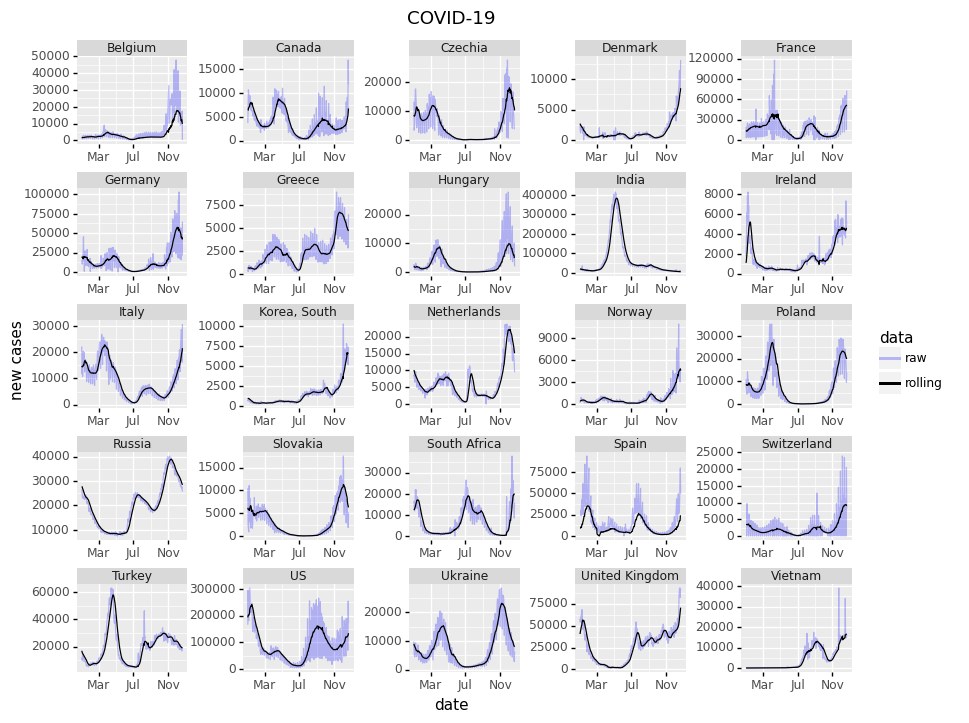

<ggplot: (8762282939552)>

In [5]:
top = rolling_new_cases.iloc[-1].nlargest(25).index
logic1 = tidy['country'].isin(top)
logic2 = tidy['date'] >= pd.Timestamp('1-1-21')
logic3 = tidy['new cases'] >= 0
pick = tidy[logic1 & logic2 & logic3]

p  = p9.ggplot(data=pick)
p += p9.theme(figure_size=(10, 8))
p += p9.scale_x_datetime(breaks=date_breaks('4 months'), labels=date_format('%b'))
p += p9.scale_color_manual(values=('blue', 'black'))
p += p9.scale_alpha_manual(values=(0.25, 1.00))
p += p9.geom_line(mapping=p9.aes(x='date', y='new cases', color='data', alpha='data'))
p += p9.ggtitle('COVID-19')
p += p9.facet_wrap('country', ncol=5, scales='free')
p += p9.theme(subplots_adjust={'hspace': 0.50, 'wspace': 0.50})

p

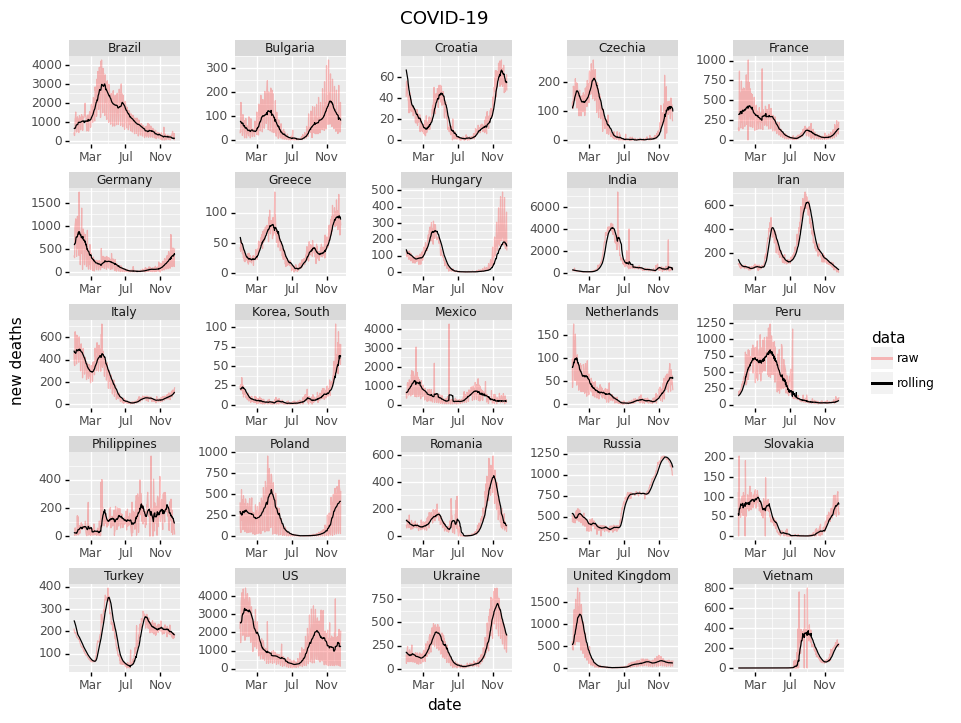

<ggplot: (8762279924854)>

In [6]:
top = rolling_new_deaths.iloc[-1].nlargest(25).index
logic1 = tidy['country'].isin(top)
logic2 = tidy['date'] >= pd.Timestamp('1-1-21')
logic3 = tidy['new deaths'] >= 0
pick = tidy[logic1 & logic2 & logic3]

p  = p9.ggplot(data=pick)
p += p9.theme(figure_size=(10, 8))
p += p9.scale_x_datetime(breaks=date_breaks('4 months'), labels=date_format('%b'))
p += p9.scale_color_manual(values=('red', 'black'))
p += p9.scale_alpha_manual(values=(0.25, 1.00))
p += p9.geom_line(mapping=p9.aes(x='date', y='new deaths', color='data', alpha='data'))
p += p9.ggtitle('COVID-19')
p += p9.facet_wrap('country', ncol=5, scales='free')
p += p9.theme(subplots_adjust={'hspace': 0.50, 'wspace': 0.50})

p

# COVID BY STATE AND COUNTY

In [7]:
import numpy as np
import pandas as pd

import plotnine as p9
from mizani.breaks import date_breaks
from mizani.formatters import date_format

## PART I: LOAD

In [8]:
pre = (
    'https://raw.githubusercontent.com/'
    'CSSEGISandData/'
    'COVID-19/master/csse_covid_19_data/'
    'csse_covid_19_time_series/')

link_cases = pre + 'time_series_covid19_confirmed_US.csv'
link_deaths = pre + 'time_series_covid19_deaths_US.csv'

csv_cases = pd.read_csv(link_cases)
csv_deaths = pd.read_csv(link_deaths)

# display(csv_cases)
# display(csv_deaths)

## PART II: CLEAN AND CALCULATE

In [9]:
drop = ['UID', 'iso2', 'iso3', 'code3', 'FIPS', 'Lat', 'Long_', 'Country_Region', 'Combined_Key']
rename = {'Admin2': 'county', 'Province_State': 'state', 'Population': 'pop'}

tidy_cases = csv_cases.drop(drop, axis=1).rename(columns=rename)
tidy_deaths = csv_deaths.drop(drop, axis=1).rename(columns=rename)

tidy_pop = tidy_deaths[['county', 'state', 'pop']]  # ???
tidy_deaths = tidy_deaths.drop('pop', axis=1)       # ???

tidy_cases = tidy_cases.melt(id_vars=['county', 'state'], var_name='date', value_name='cases')
tidy_deaths = tidy_deaths.melt(id_vars=['county', 'state'], var_name='date', value_name='deaths')

tidy_cases['date'] = tidy_cases['date'].astype('datetime64')
tidy_deaths['date'] = tidy_deaths['date'].astype('datetime64')

tidy_cases = tidy_cases.query('cases != 0')
tidy_deaths = tidy_deaths.query('deaths != 0')

tidy_cases = tidy_cases[['date', 'state', 'county', 'cases']]
tidy_deaths = tidy_deaths[['date', 'state', 'county', 'deaths']]
tidy_pop = tidy_pop[['state', 'county', 'pop']]

tidy_cases = tidy_cases.sort_values(['date', 'state'], ignore_index=True)
tidy_deaths = tidy_deaths.sort_values(['date', 'state'], ignore_index=True)

# display(tidy_cases)
# display(tidy_deaths)
# display(tidy_pop)

In [10]:
per = 10_000
rolling_window = 14

cases = tidy_cases.pivot_table(index='date', columns='state', values='cases', aggfunc='sum').fillna(0)
deaths = tidy_deaths.pivot_table(index='date', columns='state', values='deaths', aggfunc='sum').fillna(0)

pop = tidy_pop.groupby('state').sum()['pop']
pop = pop[pop != 0]

per_cases = (cases/pop*per).dropna(axis=1, how='all')
per_deaths = (deaths/pop*per).dropna(axis=1, how='all')

new_cases = cases.diff().dropna()
new_deaths = deaths.diff().dropna()
per_cases = per_cases.diff().dropna()
per_deaths = per_deaths.diff().dropna()

rolling_new_cases = new_cases.rolling(rolling_window).mean().dropna()
rolling_new_deaths = new_deaths.rolling(rolling_window).mean().dropna()
rolling_per_cases = per_cases.rolling(rolling_window).mean().dropna()
rolling_per_deaths = per_deaths.rolling(rolling_window).mean().dropna()

new_cases = new_cases.melt(ignore_index=False, value_name='new cases').reset_index()
new_deaths = new_deaths.melt(ignore_index=False, value_name='new deaths').reset_index()
per_cases = per_cases.melt(ignore_index=False, value_name='per cases').reset_index()
per_deaths = per_deaths.melt(ignore_index=False, value_name='per deaths').reset_index()

rolling_new_cases = rolling_new_cases.melt(ignore_index=False, value_name='new cases').reset_index()
rolling_new_deaths = rolling_new_deaths.melt(ignore_index=False, value_name='new deaths').reset_index()
rolling_per_cases = rolling_per_cases.melt(ignore_index=False, value_name='per cases').reset_index()
rolling_per_deaths = rolling_per_deaths.melt(ignore_index=False, value_name='per deaths').reset_index()

new_cases.insert(2, 'data', 'raw') 
new_deaths.insert(2, 'data', 'raw')
per_cases.insert(2, 'data', 'raw')
per_deaths.insert(2, 'data', 'raw')

rolling_new_cases.insert(2, 'data', 'rolling')
rolling_new_deaths.insert(2, 'data', 'rolling') 
rolling_per_cases.insert(2, 'data', 'rolling') 
rolling_per_deaths.insert(2, 'data', 'rolling')

new = pd.merge(new_cases, new_deaths, how='outer').fillna(0)
per = pd.merge(per_cases, per_deaths, how='outer').fillna(0) 

rolling_new = pd.merge(rolling_new_cases, rolling_new_deaths, how='outer')
rolling_per = pd.merge(rolling_per_cases, rolling_per_deaths, how='outer') 

raw = pd.merge(new, per, how='outer').dropna()
rolling = pd.merge(rolling_new, rolling_per, how='outer').dropna()

tidy = pd.merge(raw, rolling, how='outer').dropna()
tidy = tidy.sort_values(['date', 'state', 'data'], ignore_index=True)

tidy #.isna().sum()

,date,state,data,new cases,new deaths,per cases,per deaths
0,2020-01-23,Alabama,raw,0.000000,0.000000,0.000000,0.000000
1,2020-01-23,Alaska,raw,0.000000,0.000000,0.000000,0.000000
2,2020-01-23,American Samoa,raw,0.000000,0.000000,0.000000,0.000000
3,2020-01-23,Arizona,raw,0.000000,0.000000,0.000000,0.000000
4,2020-01-23,Arkansas,raw,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...
76869,2021-12-21,West Virginia,rolling,1019.357143,13.571429,5.687910,0.075727
76870,2021-12-21,Wisconsin,raw,4926.000000,88.000000,8.460379,0.151140
76871,2021-12-21,Wisconsin,rolling,4918.285714,51.214286,8.447130,0.087960
76872,2021-12-21,Wyoming,raw,144.000000,24.000000,2.488082,0.414680


## PART III: PLOT

In [11]:
states = [
    'Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California',
    'Colorado', 'Connecticut', 'Delaware', 'Florida', 'Georgia',
    'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa',
    'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland',
    'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi', 'Missouri',
    'Montana', 'Nebraska', 'Nevada', 'New Hampshire', 'New Jersey',
    'New Mexico', 'New York', 'North Carolina', 'North Dakota', 'Ohio',
    'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island', 'South Carolina',
    'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Vermont',
    'Virginia', 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming']

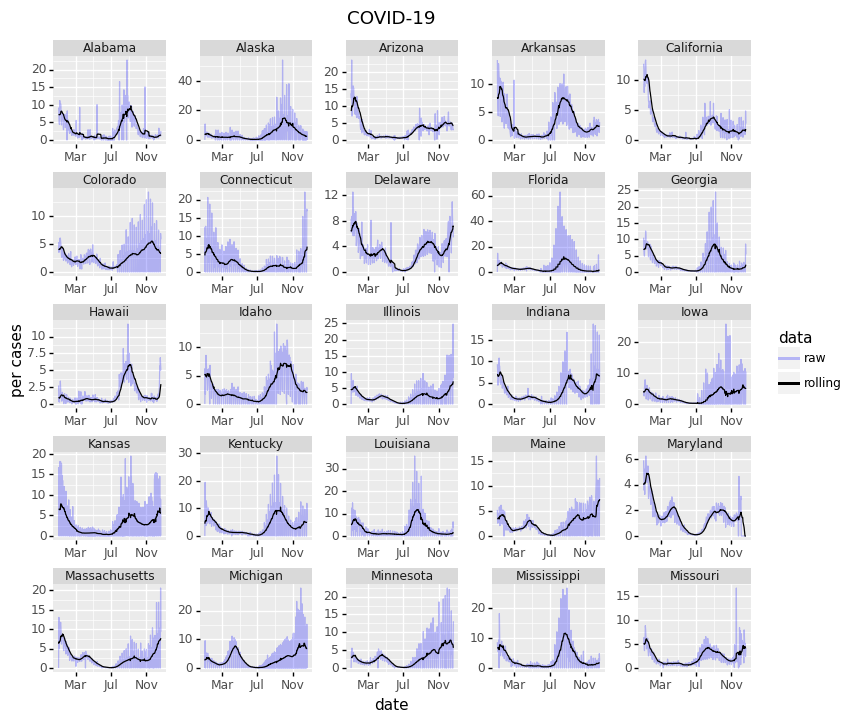

<ggplot: (8762246249578)>

In [12]:
top = states[0:25]

logic1 = tidy['state'].isin(top)
logic2 = tidy['date'] >= pd.Timestamp('1-1-21')
logic3 = tidy['new cases'] >= 0
pick = tidy[logic1 & logic2 & logic3]

p  = p9.ggplot(data=pick)
p += p9.theme(figure_size=(9, 8))
p += p9.scale_x_datetime(breaks=date_breaks('4 months'), labels=date_format('%b'))
p += p9.geom_line(mapping=p9.aes(x='date', y='per cases', color='data', alpha='data'))
p += p9.scale_color_manual(values=('blue', 'black'))
p += p9.scale_alpha_manual(values=(0.25, 1.00))
p += p9.ggtitle('COVID-19')
p += p9.theme(subplots_adjust={'hspace': 0.50, 'wspace': 0.30})
p += p9.facet_wrap('state', ncol=5, scales='free')

p

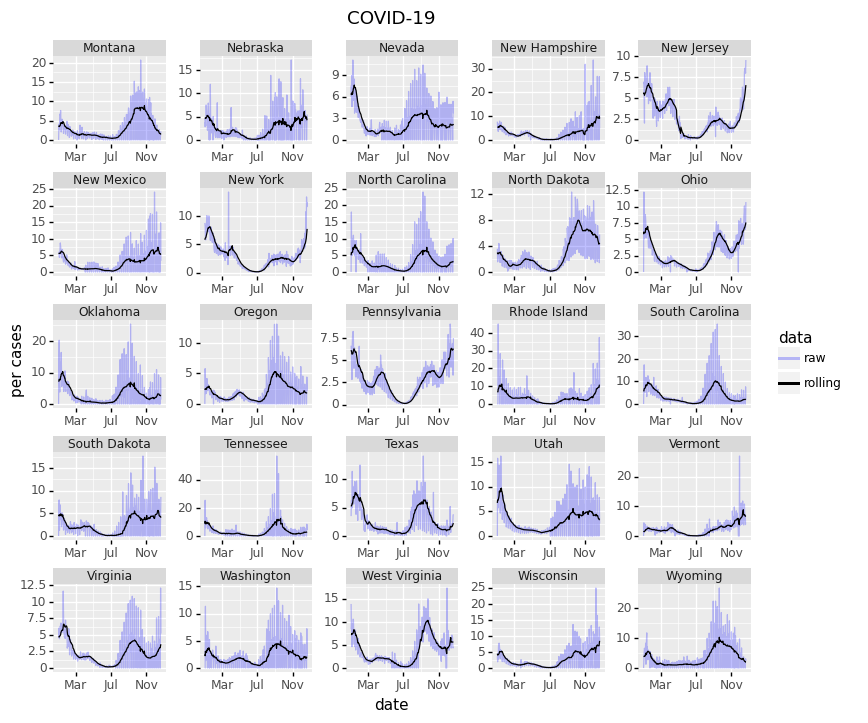

<ggplot: (8762245827154)>

In [13]:
top = states[25:50]

logic1 = tidy['state'].isin(top)
logic2 = tidy['date'] >= pd.Timestamp('1-1-21')
logic3 = tidy['new cases'] >= 0
pick = tidy[logic1 & logic2 & logic3]

p  = p9.ggplot(data=pick)
p += p9.theme(figure_size=(9, 8))
p += p9.scale_x_datetime(breaks=date_breaks('4 months'), labels=date_format('%b'))
p += p9.geom_line(mapping=p9.aes(x='date', y='per cases', color='data', alpha='data'))
p += p9.scale_color_manual(values=('blue', 'black'))
p += p9.scale_alpha_manual(values=(0.25, 1.00))
p += p9.ggtitle('COVID-19')
p += p9.theme(subplots_adjust={'hspace': 0.50, 'wspace': 0.30})
p += p9.facet_wrap('state', ncol=5, scales='free')

p

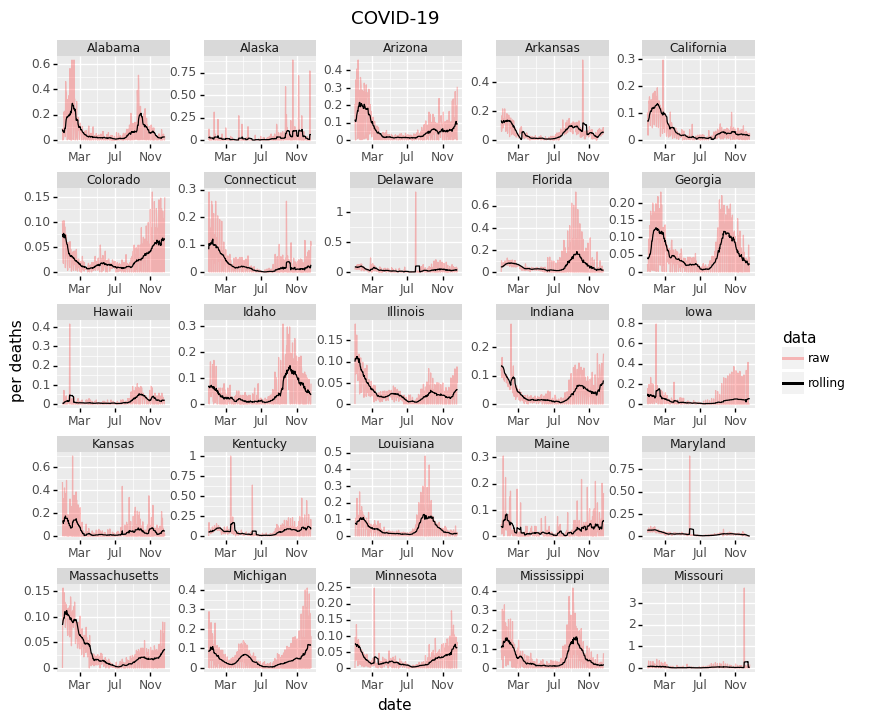

<ggplot: (8762245827130)>

In [14]:
top = states[0:25]

logic1 = tidy['state'].isin(top)
logic2 = tidy['date'] >= pd.Timestamp('1-1-21')
logic3 = tidy['new deaths'] >= 0
pick = tidy[logic1 & logic2 & logic3]

p  = p9.ggplot(data=pick)
p += p9.theme(figure_size=(9, 8))
p += p9.scale_x_datetime(breaks=date_breaks('4 months'), labels=date_format('%b'))
p += p9.geom_line(mapping=p9.aes(x='date', y='per deaths', color='data', alpha='data'))
p += p9.scale_color_manual(values=('red', 'black'))
p += p9.scale_alpha_manual(values=(0.25, 1.00))
p += p9.ggtitle('COVID-19')
p += p9.theme(subplots_adjust={'hspace': 0.50, 'wspace': 0.30})
p += p9.facet_wrap('state', ncol=5, scales='free')

p

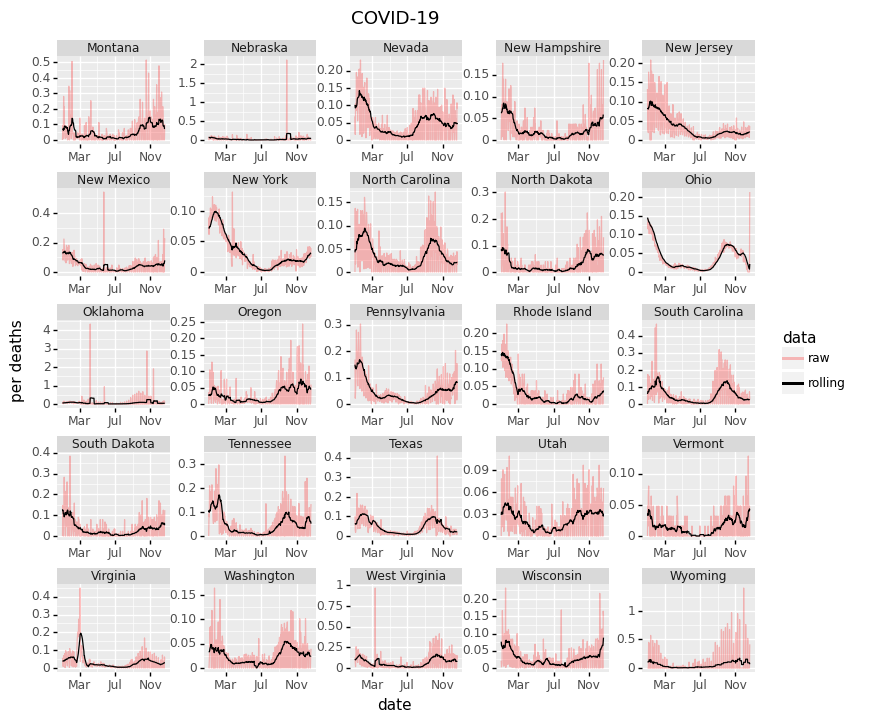

<ggplot: (8762247158254)>

In [15]:
top = states[25:50]

logic1 = tidy['state'].isin(top)
logic2 = tidy['date'] >= pd.Timestamp('1-1-21')
logic3 = tidy['new deaths'] >= 0
pick = tidy[logic1 & logic2 & logic3]

p  = p9.ggplot(data=pick)
p += p9.theme(figure_size=(9, 8))
p += p9.scale_x_datetime(breaks=date_breaks('4 months'), labels=date_format('%b'))
p += p9.geom_line(mapping=p9.aes(x='date', y='per deaths', color='data', alpha='data'))
p += p9.scale_color_manual(values=('red', 'black'))
p += p9.scale_alpha_manual(values=(0.25, 1.00))
p += p9.ggtitle('COVID-19')
p += p9.theme(subplots_adjust={'hspace': 0.50, 'wspace': 0.30})
p += p9.facet_wrap('state', ncol=5, scales='free')

p

In [24]:
per = 10_000
rolling_window = 14

cases = tidy_cases.query('state == "Hawaii"')
cases = cases.pivot(index='date', columns='county', values='cases').fillna(0)
cases = cases.drop(['Kalawao', 'Out of HI', 'Unassigned'], axis=1)

deaths = tidy_deaths.query('state == "Hawaii"')
deaths = deaths.pivot(index='date', columns='county', values='deaths').fillna(0)
deaths = deaths.drop(['Out of HI', 'Unassigned'], axis=1)

pop = tidy_pop.query('state == "Hawaii"')
pop = pop.set_index('county')['pop']
pop = pop.drop(['Kalawao', 'Out of HI', 'Unassigned'])

In [25]:
per_cases = (cases/pop*per).dropna(axis=1, how='all')
per_deaths = (deaths/pop*per).dropna(axis=1, how='all')

new_cases = cases.diff().dropna()
new_deaths = deaths.diff().dropna()
per_cases = per_cases.diff().dropna()
per_deaths = per_deaths.diff().dropna()

rolling_new_cases = new_cases.rolling(rolling_window).mean().dropna()
rolling_new_deaths = new_deaths.rolling(rolling_window).mean().dropna()
rolling_per_cases = per_cases.rolling(rolling_window).mean().dropna()
rolling_per_deaths = per_deaths.rolling(rolling_window).mean().dropna()

new_cases = new_cases.melt(ignore_index=False, value_name='new cases').reset_index()
new_deaths = new_deaths.melt(ignore_index=False, value_name='new deaths').reset_index()
per_cases = per_cases.melt(ignore_index=False, value_name='per cases').reset_index()
per_deaths = per_deaths.melt(ignore_index=False, value_name='per deaths').reset_index()

rolling_new_cases = rolling_new_cases.melt(ignore_index=False, value_name='new cases').reset_index()
rolling_new_deaths = rolling_new_deaths.melt(ignore_index=False, value_name='new deaths').reset_index()
rolling_per_cases = rolling_per_cases.melt(ignore_index=False, value_name='per cases').reset_index()
rolling_per_deaths = rolling_per_deaths.melt(ignore_index=False, value_name='per deaths').reset_index()

new_cases.insert(2, 'data', 'raw') 
new_deaths.insert(2, 'data', 'raw')
per_cases.insert(2, 'data', 'raw')
per_deaths.insert(2, 'data', 'raw')

rolling_new_cases.insert(2, 'data', 'rolling')
rolling_new_deaths.insert(2, 'data', 'rolling') 
rolling_per_cases.insert(2, 'data', 'rolling') 
rolling_per_deaths.insert(2, 'data', 'rolling')

new = pd.merge(new_cases, new_deaths, how='outer').fillna(0)
per = pd.merge(per_cases, per_deaths, how='outer').fillna(0) 

rolling_new = pd.merge(rolling_new_cases, rolling_new_deaths, how='outer')
rolling_per = pd.merge(rolling_per_cases, rolling_per_deaths, how='outer') 

raw = pd.merge(new, per, how='outer').dropna()
rolling = pd.merge(rolling_new, rolling_per, how='outer').dropna()

tidy = pd.merge(raw, rolling, how='outer').dropna()
tidy = tidy.sort_values(['date', 'county', 'data'], ignore_index=True)

tidy #.isna().sum()

,date,county,data,new cases,new deaths,per cases,per deaths
0,2020-03-08,Hawaii,raw,0.000000,0.000000,0.000000,0.000000
1,2020-03-08,Honolulu,raw,0.000000,0.000000,0.000000,0.000000
2,2020-03-08,Kauai,raw,0.000000,0.000000,0.000000,0.000000
3,2020-03-08,Maui,raw,0.000000,0.000000,0.000000,0.000000
4,2020-03-09,Hawaii,raw,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...
5079,2021-12-21,Honolulu,rolling,355.857143,2.071429,3.651453,0.021255
5080,2021-12-21,Kauai,raw,10.000000,0.000000,1.383260,0.000000
5081,2021-12-21,Kauai,rolling,11.642857,0.071429,1.610510,0.009880
5082,2021-12-21,Maui,raw,26.000000,0.000000,1.553008,0.000000


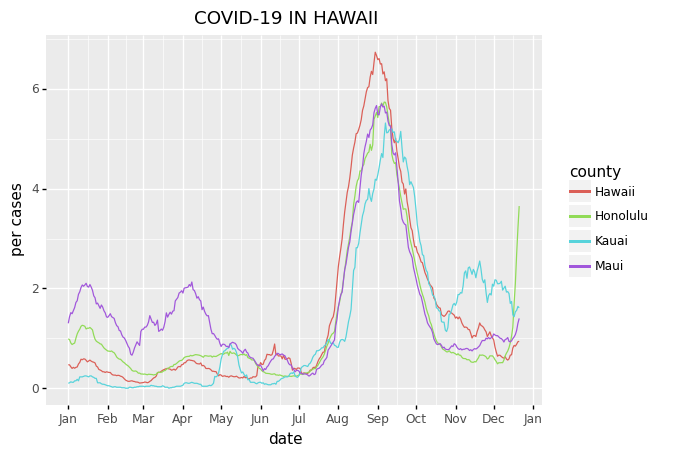

<ggplot: (8762245993024)>

In [26]:
logic1 = tidy['data'] == 'rolling'
logic2 = tidy['date'] >= pd.Timestamp('1-1-21')
logic3 = tidy['new cases'] >= 0
pick = tidy[logic1 & logic2 & logic3]

p  = p9.ggplot(data=pick)
# p += p9.theme(figure_size=(9, 8))
p += p9.scale_x_datetime(breaks=date_breaks('1 months'), labels=date_format('%b'))
p += p9.geom_line(mapping=p9.aes(x='date', y='per cases', color='county'))
p += p9.ggtitle('COVID-19 IN HAWAII')

p